# Exploratory Analysis Notebook
A set of tools to analyse the intents within your workspace.

**Author:** Kalyan Dutia (kalyan.dutia@ibm.com)

In [1]:
# external imports
import os
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
from itables import show

# internal imports
import config
import cli_tools.download_intents as download_intents
from cli_tools.get_intent_intersections import intent_intersections
from for_csv.chi2_feat_select import chi2_feat_select

# config
sns.set_style("whitegrid")
sns.set_context("notebook")
pd.set_option('display.max_colwidth', -1) # change from -1

<IPython.core.display.Javascript object>

## Get Training Data
This will be stored in the *data/workspace_training* folder, with the format [workspace-name]_questions.csv

### View existing data, import if necessary

First, view the files in the training data folder:

In [2]:
def view_training_files():
    training_files = [file for file in os.listdir(config.training_dir) if file.endswith('.csv')]
    training_files

    display(Markdown("**Training data files:**"))
    display(Markdown((''.join([' - {}\n'.format(i) for i in training_files]))))
    
    return training_files
        
training_files = view_training_files()

**Training data files:**

 - Puppy_questions.csv
 - Phone Advisor_questions.csv
 - Puppy_Training_Data.csv


If you need to update the training data files, you can use the button below. 

In [3]:
def download_intents_button_onclick(_):
    download_intents.main()
    training_files = view_training_files()
    
button = widgets.Button(description='Update intent training files')
button.on_click(download_intents_button_onclick)

display(button)

Button(description='Update intent training files', style=ButtonStyle())

### Select a skill
Use the dropdown box, and use the following cell to confirm your selection.

In [61]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d)
        display_sample(d, 10)
        
def get_training(d):
    training_file = training_files[d.index]
    return pd.read_csv(os.path.join(config.training_dir, training_file), names=['utterance', 'intent'])

def display_sample(d, samplesize):
    if samplesize != None:
        display(Markdown("**<span style='color:blue'>{}</span>** skill selected. Training data sample:".format(d.value)))
    
    train_df = get_training(d)
    
    if (len(train_df) > 0) & (samplesize != None):
        display(train_df.sample(samplesize))
    elif samplesize:
        display(Markdown("<span style='color:red'>No intent training data exists for this workspace</span>"))
    
    return train_df

d = widgets.Dropdown(options=[item[0:len(item)-14] for item in training_files])
d.observe(onchange)

display(d)

Dropdown(index=1, options=('Puppy', 'Phone Advisor', 'Puppy_Tra'), value='Phone Advisor')

**<span style='color:blue'>Phone Advisor</span>** skill selected. Training data sample:

,utterance,intent
49,hi,Greeting
50,hola,Greeting
27,I like android phones,positive
7,Tell me more about the Galaxy S9,phoneinfo
13,Here's a review of my phone,submitreview
52,hey,Greeting
17,Gary Numan,collectname
18,They call me Manuel Cardenas,collectname
1,Tell me about the google pixel 3,phoneinfo
10,Let me give you my opinions on apple phones,submitreview


In [63]:
train_df = get_training(d)
intents = train_df['intent'].unique()

## Analysis

### Intent Sizes
As a general rule of thumb, your intents should be sized relative to the amount of scope they cover. If this is not the case, you might want to check for redundancy in your intents later on.

If your largest intent is greater than two times your smallest, a warning will appear below.

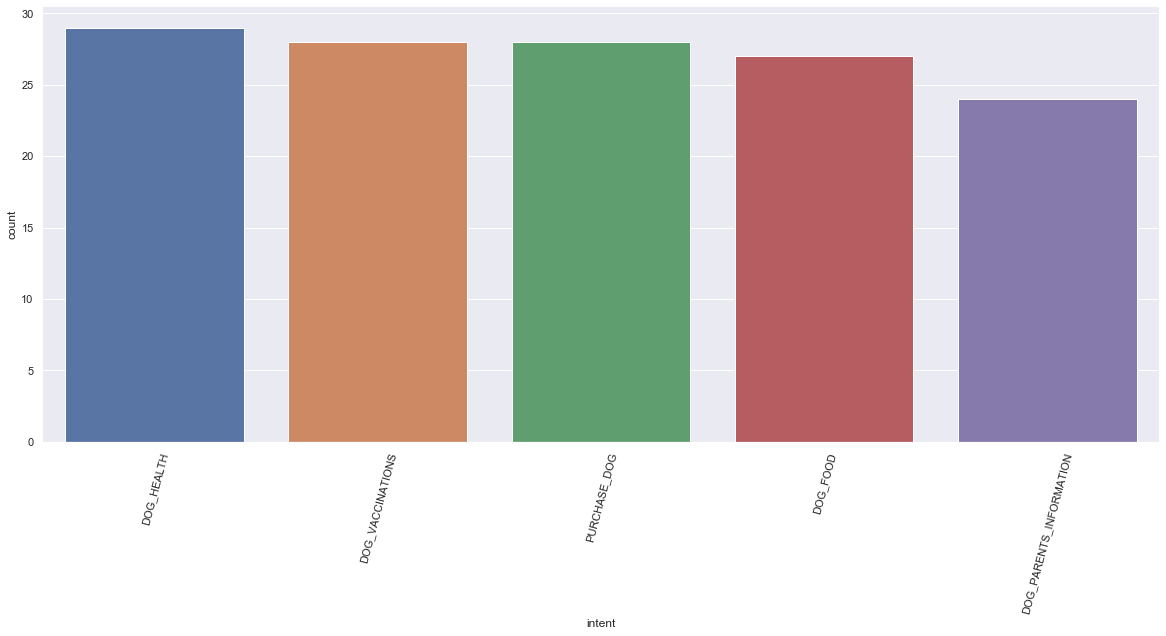

In [16]:
train_df = display_sample(d, None)
intent_sizes = train_df.groupby('intent').count()
intent_max_min_ratio = intent_sizes.max()[0] / intent_sizes.min()[0]

if intent_max_min_ratio > 2:
    display(Markdown("**<span style='color:darkorange'>Warning:</span>** Your largest intent is {}x larger than your smallest".format(round(intent_max_min_ratio, 2))))

sns.set(rc={'figure.figsize':(20,8)})
ax = sns.countplot(data=train_df, x='intent', order=train_df['intent'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75);
sns.despine(left=True)

### Representative 1- and 2-grams
In this section we use chi-squared feature selection to bring out the terms which most represent each intent in your workspace. 

Here, you should be thinking about:
<ol type="a">
    <li>whether these terms are what you'd expect for each intent</li>
    <li>if any of these terms would be good candidates for resting entities</li>
</ol>

In [25]:
K=5

chi2 = chi2_feat_select(train_df)
chi2.getKbest(K)

,DOG_FOOD,DOG_HEALTH,DOG_PARENTS_INFORMATION,DOG_VACCINATIONS,PURCHASE_DOG
top unigrams,"dogs, sell, feed, eat, food","chow, night, health, sick, tell","meet, mum, parents, father, mother","injections, vaccinated, shots, jabs, vaccinations","pricing, purchase, want, chinook, buy"
top bigrams,"puppy eat, dogs food, food sell, dogs eat, dog food","pups happy, dogs depression, dog properly, dog ill, tell puppy","meet father, father pedigree, mother litter, look parents, puppy father","vaccinate dogs, puppies vaccinated, shots dogs, puppy injections, jabs puppy","buy puppy, want buy, buy chinook, like buy, buy dog"


### Clashes between Intents
The matrix below shows the number of shared ngrams in utterances between intents. A high number means there is a greater overlap between the intents, which should be investigated.

In [29]:
ngram_list = [4,5] 
stopwords = 'none' # stopwords_in can be none, nltk, or config

In [30]:
ii = intent_intersections(ngram_list, stopwords_in=stopwords, intent_col='intent')
ii.import_training_df(train_df)
intersection_df, intersection_size_df = ii.calculate_ngram_intersections()

intersection_size_df = intersection_size_df.fillna(0)

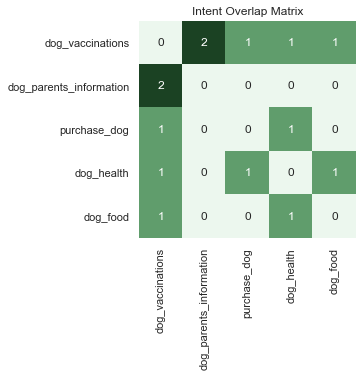

In [31]:
heatmap_colors = sns.cubehelix_palette(8, start=2, rot=0, dark=0.2, light=.95, reverse=False)
ax = sns.heatmap(intersection_size_df, annot=True, cmap=heatmap_colors, cbar=False, square=True)
ax.set_title('Intent Overlap Matrix');

You can then investigate specific intent overlaps:

In [32]:
def onchange(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(d01)
        display(d02)
        display_intent_overlap(d01.value, d02.value)

def display_intent_overlap(intent1, intent2):
    if d01.value != d02.value:
        ngrams_per_intent_df, ngram_freq_df = ii.get_ngrams_per_intent()
        overlap_df = ii.get_intersection_freqs([intent1, intent2], ngram_freq_df)
        overlap_df = overlap_df.sort_values([intent1, intent2], ascending=False)
        display(overlap_df)
    else:
        display(Markdown("Intents chosen can't be the same"))

d01 = widgets.Dropdown(options=train_df['intent'].unique())
d02 = widgets.Dropdown(options=train_df['intent'].unique())

d01.observe(onchange)
d02.observe(onchange)

display(d01)
display(d02)
display_intent_overlap(d01.value, d02.value)

Dropdown(options=('dog_vaccinations', 'dog_parents_information', 'purchase_dog', 'dog_health', 'dog_food'), va…

Dropdown(index=2, options=('dog_vaccinations', 'dog_parents_information', 'purchase_dog', 'dog_health', 'dog_f…

,dog_vaccinations,purchase_dog
i want to get,1.0,1.0


In [37]:
display(Markdown("You can use the table below to search through training utterances."))
show(train_df[['utterance', 'intent']])

You can use the table below to search through training utterances.

utterance,intent
